In [2]:
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
import torch
import pandas as pd
import time
import os
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
import sqlite3
from glob import glob

from tqdm import tqdm



In [48]:
chats_path = '../material/chats.db'
conn = sqlite3.connect(chats_path)
cursor=conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables=cursor.fetchall()

# ========================
# 1. Leggi chats.db (SQLite)
# ========================

print("📌 Tabelle nel DB:", tables)

try:
    df_chats = pd.read_sql_query("SELECT * FROM chats", conn)
    print("✅ chats.db - Tabella 'chats'")
    print(df_chats.head())
except Exception as e:
    print("⚠️ Errore nel leggere la tabella:", e)

conn.close()

# ========================
# 2. Leggi discovery_edges.csv.gz
# ========================
try:
    df_edges = pd.read_csv('../material/discovery_edges.csv.gz')
    print("✅ discovery_edges.csv.gz, \n" \
    "Il timestamp da l'ultima volta che hanno visitato quel gruppo ma questo significa che non è davvero indicativo di una timeline \n")
    print(df_edges.head())
except Exception as e:
    print("⚠️ Errore nel leggere discovery_edges:", e)

# ========================
# 3. Leggi first_nodes.csv.gz
# ========================
try:
    df_first_nodes = pd.read_csv('../material/first_nodes.csv.gz')
    print("✅ first_nodes.csv.gz")
    print(df_first_nodes.head())
    print(len(df_first_nodes))
except Exception as e:
    print("⚠️ Errore nel leggere first_nodes:", e)


📌 Tabelle nel DB: [('chats',)]
✅ chats.db - Tabella 'chats'
  type_and_id                            token parent     timestamp
0        None           [keyword] thedemocrats   None  1.722583e+09
1        None  [keyword] makeamericagreatagain   None  1.722583e+09
2        None                   [keyword] MAGA   None  1.722583e+09
3        None            [keyword] Nikki Haley   None  1.722583e+09
4        None  [keyword] Robert F. Kennedy Jr.   None  1.722583e+09
✅ discovery_edges.csv.gz, 
Il timestamp da l'ultima volta che hanno visitato quel gruppo ma questo significa che non è davvero indicativo di una timeline 

          type_and_id              parent     timestamp
0  channel_1306559115  channel_1840578235  1.722586e+09
1  channel_2036850729  channel_1840578235  1.722586e+09
2  channel_1941222046  channel_1840578235  1.722586e+09
3  channel_1749991917  channel_1840578235  1.722586e+09
4  channel_1581117699  channel_1840578235  1.722586e+09
✅ first_nodes.csv.gz
          type_and_

In [50]:
df_first_nodes.type_and_id.nunique()

247

In [4]:
# Fare preprocessing dei testi:
import os
import re
from typing import Callable, Union
import numpy as np
import pandas as pd
# import spacy
# from sklearn.feature_extraction.text import TfidfVectorizer
# from tqdm import tqdm
from unidecode import unidecode
import langdetect


class PreProcessing:
    """Class for performing text preprocessing operations.

    Args:
        noadverbs (bool, optional): Flag to remove adverbs from the text. Defaults to False.
        noadjectives (bool, optional): Flag to remove adjectives from the text. Defaults to False.
        noverbs (bool, optional): Flag to remove verbs from the text. Defaults to False.
        noentities (bool, optional): Flag to remove named entities from the text. Defaults to False.
        language (str, optional): Language for the Spacy model. Defaults to 'en'.
        remove_list (bool, optional): Flag to remove a list of words from the text. Defaults to False.

    Attributes:
        noadverbs (bool): Flag to remove adverbs from the text.
        noadjectives (bool): Flag to remove adjectives from the text.
        noverbs (bool): Flag to remove verbs from the text.
        noentities (bool): Flag to remove named entities from the text.
        language (str): Language for the Spacy model.
        remove_list (bool): Flag to remove a list of words from the text.
        punctuation (str): Regular expression pattern for removing punctuation.
        nlp (spacy.Language): Spacy language model.
        stopwords (list): List of stopwords.

    Methods:
        lowercase_unidecode: Converts text to lowercase and removes diacritics.
        remove_urls: Removes URLs from the text.
        remove_tweet_marking: Removes Twitter mentions and hashtags from the text.
        remove_punctuation: Removes punctuation from the text.
        remove_repetion: Removes repeated words from the text.
        append_stopwords_list: Appends additional stopwords to the existing list.
        remove_stopwords: Removes stopwords from the text.
        remove_n: Removes words with length less than or equal to n from the text.
        remove_numbers: Removes or filters out numbers from the text.
        remove_gerund: Removes gerund endings from verbs in the text.
        remove_infinitive: Removes infinitive endings from verbs in the text.
        filter_by_idf: Filters out words based on their inverse document frequency.

    """

    def __init__(self, noadverbs: bool = False, noadjectives: bool = False, noverbs: bool = False,
                 noentities: bool = False, language: str = 'en', remove_list: bool = False,stopwords=[]):
        """Initialize the PreProcessing object.

        Args:
            noadverbs (bool, optional): Flag to indicate whether to remove adverbs. Defaults to False.
            noadjectives (bool, optional): Flag to indicate whether to remove adjectives. Defaults to False.
            noverbs (bool, optional): Flag to indicate whether to remove verbs. Defaults to False.
            noentities (bool, optional): Flag to indicate whether to remove named entities. Defaults to False.
            remove_list (bool, optional): Flag to indicate whether to remove stopwords. Defaults to False.
        """
        self.noadverbs = noadverbs
        self.noadjectives = noadjectives
        self.noverbs = noverbs
        self.noentities = noentities
        self.remove_list = remove_list
        self.punctuation = (
                r'\(|!|"|#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|\/|'
                r':|;|<|=|>|\?|\@|\[|\]|\^|_|`|\{|\}|~|\||'
                r'\r\n|\n|\r|\\\)'
        )
        # self.nlp = self._load_spacy_model(language)
        # self.stopwords = [unidecode(x).lower() for x in list(self.nlp.Defaults.stop_words)]
        self.stopwords=stopwords



    
    def _process_text(self, text: Union[str, list], function: Callable) -> Union[str, list]:

        if isinstance(text, str):
            return function(text)
        elif isinstance(text, list):
            return [function(x) for x in text]
        return ''
    
    
    def lowercase_unidecode(self, text: Union[str, list]) -> Union[str, list]:
        """Convert the given text to lowercase and remove any diacritical marks (accents).

        Args:
            text (Union[str, list]): The text to be processed. It can be either a string or a list of strings.

        Returns:
            Union[str, list]: The processed text. If the input is a string, the output will be a string. If the input is a list,
            the output will be a list of strings.

        Example:
            >>> pre_processor = PreProcessor()
            >>> text = "Café"
            >>> pre_processor.lowercase_unidecode(text)
            'cafe'
        """
        from unidecode import unidecode
        text = self._process_text(text, lambda value: value.lower())
        text = self._process_text(text, unidecode)
        return text

    def remove_urls(self, text: Union[str, list]) -> Union[str, list]:
        """Removes URLs from the given text or list of texts.

        Args:
            text (Union[str, list]): The text or list of texts from which to remove URLs.

        Returns:
            Union[str, list]: The text or list of texts with URLs removed.

        """
        return self._process_text(text, lambda value: re.sub(r'http\S+ *', '', value).strip())

    def remove_tweet_marking(self, text: Union[str, list]) -> Union[str, list]:
        """Removes tweet markings (e.g., @mentions and #hashtags) from the given text.

        Args:
            text (Union[str, list]): The text or list of texts to process.

        Returns:
            Union[str, list]: The processed text or list of processed texts with tweet markings removed.
        """
        return self._process_text(text, lambda value: re.sub(r'(@|#)\S+ *', '', value).strip())

    def remove_html_tags(self, text: Union[str, list]) -> Union[str, list]:
        """Removes HTML tags from the given text.

        Args:
            text (Union[str, list]): The text or list of texts to process.

        Returns:
            Union[str, list]: The processed text or list of processed texts with HTML tags removed.
        """
        return self._process_text(text, lambda value: re.sub(r'<.*?> *', '', value).strip())

    def remove_punctuation(self, text: Union[str, list]) -> Union[str, list]:
        """Removes punctuation from the given text.

        Args:
            text (Union[str, list]): The text from which punctuation needs to be removed.

        Returns:
            Union[str, list]: The text with punctuation removed.
        """
        text = self._process_text(text, lambda value: re.sub(self.punctuation, ' ', value))
        text = self._process_text(text, lambda value: re.sub(' {2,}', ' ', value).strip())
        return text

    def remove_repetition(self, text: Union[str, list]) -> Union[str, list]:
        """Removes repeated words in the given text.

        Args:
            text (Union[str, list]): The input text or list of words.

        Returns:
            Union[str, list]: The processed text with repeated words removed.

        """
        return self._process_text(text, lambda value: re.sub(r'\b(\w+)\s+\1\b', r'\1', value))

    def append_stopwords_list(self, stopwords: list) -> None:
        """Appends additional stopwords to the existing list of stopwords.

        Parameters:
        stopwords (list): A list of stopwords to be appended.

        """
        self.stopwords.extend(stopwords)

    def remove_stopwords(self, text: Union[str, list]) -> Union[str, list]:
        """Removes stopwords from the given text.

        Args:
            text (Union[str, list]): The input text from which stopwords need to be removed.

        Returns:
            Union[str, list]: The processed text with stopwords removed.

        """
        return self._process_text(text, lambda value: re.sub(rf'\b({"|".join(self.stopwords)})\b *', '', value).strip())

    

    def remove_n(self, text: Union[str, list], n: int) -> Union[str, list]:
        """Removes words of length 1 to n followed by the word 'pri' from the given text.

        Args:
            text (Union[str, list]): The input text or list of texts to process.
            n (int): The maximum length of words to remove.

        Returns:
            Union[str, list]: The processed text or list of processed texts.

        """
        return self._process_text(text, lambda value: re.sub(rf'(\b|^)\w{{1,{n}}}(\b|$) ?', '', value).strip())

    def remove_numbers(self, text: Union[str, list], mode: str = 'replace') -> Union[str, list]:
        """Removes or replaces numbers in the given text.

        Args:
            text (Union[str, list]): The input text or list of texts.
            mode (str, optional): The mode of operation. Defaults to 'replace'.
                - 'filter': Removes the numbers from the text.
                - 'replace': Replaces the numbers with an empty string.

        Returns:
            Union[str, list]: The processed text or list of processed texts.
        """
        if mode == "filter":
            return self._process_text(text, lambda value: '' if re.search('[0-9]', value) else value)
        elif mode == "replace":
            return self._process_text(text, lambda value: re.sub('[0-9] *', '', value))

    def remove_gerund(self, text: Union[str, list]) -> Union[str, list]:
        """Removes the gerund form '-ndo' from the given text.

        Args:
            text (Union[str, list]): The input text or list of texts to process.

        Returns:
            Union[str, list]: The processed text with the gerund form removed.

        """
        return self._process_text(text, lambda value: re.sub(r'ndo\b', '', value))

    def remove_infinitive(self, text: Union[str, list]) -> Union[str, list]:
        """Removes the infinitive form of verbs from the given text.

        Args:
            text (Union[str, list]): The input text or list of texts to process.

        Returns:
            Union[str, list]: The processed text with infinitive forms removed.

        """
        return self._process_text(text, lambda value: re.sub(r'r\b', '', value))
    
    
    def detect_language(self,text):
        import langdetect
        try:
            d=langdetect.detect_langs(text)
            # Trasforma la lista in un dizionario
            langs_dict = {lang.lang: lang.prob for lang in d}
            best_lang=max(langs_dict,key=langs_dict.get)
            best_lang=best_lang if langs_dict[best_lang]>=0.7 else 'unk'
            return best_lang    
        except langdetect.LangDetectException as e:
            return 'unk'
        return None


from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

# here the funziona to call to preprocess the text
def preprocess_text(text,stopwords=stopwords):
    
    pp=PreProcessing(language='en',stopwords=stopwords)
    
    # Preprocessing pipeline
    text = pp.lowercase_unidecode(text)
    
    if pp.detect_language(text)!='en':
        return ""
    
    text = pp.remove_stopwords(text)
    text = pp.remove_tweet_marking(text)
    text = pp.remove_urls(text)
    text = pp.remove_repetition(text)
    text = pp.remove_punctuation(text)
    text = pp.remove_numbers(text)
    text = pp.remove_n(text, n=3)
    return text


In [5]:
#df = pd.concat(([pd.read_csv(file, sep='\t') for file in tqdm(glob('sample/*.csv'))]), ignore_index=True)
#df=df.drop_duplicates(subset=['processed_text'])

# DA PORTATILE SCOMMENTARE QUESTO
#extracted_dir = os.path.join("..", "material", "extracted")

#------------------------------------------------
#DA JUPYTER CUSTER SCOMMENTARE QUESTO
extracted_dir = os.path.expanduser("~/telegram_2024/usc-tg-24-us-election/extracted")

print("1-------------------------------\n")

# cerca tutti i file .tsv.gz dentro tutte le cartelle channel_*
all_files = glob(os.path.join(extracted_dir, "channel_*", "*.tsv.gz"))

#take only the first 3 files
all_files = all_files[:10]

print("2-------------------------------\n")

# leggi tutti i file e concatena in un unico DataFrame
df = pd.concat(
    [pd.read_csv(file, sep='\t', compression='gzip') for file in tqdm(all_files)],
    ignore_index=True
)

print("3-------------------------------\n")

# preprocess the text
print(preprocess_text("Ciao, come va?") + "\n\n")

df["processed_text"] = df["text"].apply(preprocess_text)

print("4-------------------------------\n")

# rimuovi i duplicati sulla colonna "processed_text"
df = df.drop_duplicates(subset=["processed_text"])

print(df.head(1))



1-------------------------------

2-------------------------------



100%|██████████| 10/10 [00:00<00:00, 207.36it/s]

3-------------------------------






4-------------------------------

        id       user_id                                               text  \
0  89176.0  6.411871e+09  I’m scouting for new crypto opportunities, any...   

      timestamp  bot_flag  via_bot_id  via_business_bot_id  reply_to_msg_id  \
0  1.714622e+09       NaN         NaN                  NaN              NaN   

   fwd_flag  fwd_from_id  ... forwards  replies  reactions  reaction_json  \
0       NaN          NaN  ...      NaN      3.0        0.0            NaN   

   bot verified first_name last_name username  \
0  NaN      NaN        NaN       NaN      NaN   

                       processed_text  
0  scouting crypto opportunities tips  

[1 rows x 22 columns]


In [ ]:


os.environ["TOKENIZERS_PARALLELISM"] = "true"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model_name = 'all-distilroberta-v1'
embedding_model=SentenceTransformer(model_name)

umap_params = {'n_components': 5, 'n_neighbors': 5, 'min_dist': 0.0}

hdbscan_params = {'min_cluster_size': 500,'min_samples':100,'prediction_data':True}

if os.path.exists(f'final/final_embeddings_{model_name}.npy'):
    embeddings = np.load(f'final/final_embeddings_{model_name}.npy')
    print(f'embedding {model_name} loaded')
else:
    embedding_model = embedding_model.to(device)
    embeddings = embedding_model.encode(df['processed_text'].tolist(), show_progress_bar=True, device=device)
    np.save(f'final/final_embeddings_{model_name}.npy', embeddings)


In [38]:
"""
-----An entry of ~/telegram_2024/usc-tg-24-us-election/extracted/channel_2144322933/2024-03.tsv.gz
   id       user_id text   timestamp  bot_flag  via_bot_id  \
0   5  6.897729e+09  Hii  1711518674       NaN         NaN   

   via_business_bot_id  reply_to_msg_id  fwd_flag  fwd_from_id media_type  \
0                  NaN              NaN       NaN          NaN        NaN   

   views  forwards  replies  reactions reaction_json  
0    NaN       NaN        0          0           NaN


📌 Tabelle nel DB: [('chats',)]
✅ chats.db - Tabella 'chats'
  type_and_id                            token parent     timestamp
0        None           [keyword] thedemocrats   None  1.722583e+09
1        None  [keyword] makeamericagreatagain   None  1.722583e+09
2        None                   [keyword] MAGA   None  1.722583e+09
3        None            [keyword] Nikki Haley   None  1.722583e+09
4        None  [keyword] Robert F. Kennedy Jr.   None  1.722583e+09
✅ discovery_edges.csv.gz, 
Il timestamp da l'ultima volta che hanno visitato quel gruppo ma questo significa che non è davvero indicativo di una timeline 

          type_and_id              parent     timestamp
0  channel_1306559115  channel_1840578235  1.722586e+09
1  channel_2036850729  channel_1840578235  1.722586e+09
2  channel_1941222046  channel_1840578235  1.722586e+09
3  channel_1749991917  channel_1840578235  1.722586e+09
4  channel_1581117699  channel_1840578235  1.722586e+09
✅ first_nodes.csv.gz
          type_and_id                    token                      parent
0  channel_2036421633               trump2024e         [keyword] Trump2024
1  channel_2178554925  biden_has_left_the_chat             [keyword] Biden
2  channel_2095394414             speech_biden      [keyword] Joseph Biden
3  channel_2202860593       republicanpartyeth  [keyword] Republican party
4  channel_2157448164      republican_partysol  [keyword] Republican party

"""

from multiprocessing import Pool, cpu_count
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

print(cpu_count())

# Lista per accumulare tutti i messaggi in inglese
all_english_messages = []

pp2 = PreProcessing(language='en', noentities=True, stopwords=stopwords)

# Wrapper function for multiprocessing
def process_file(args):
    file, channel_id, token = args
    try:
        df = pd.read_csv(file, sep='\t', compression='gzip', usecols=['text','timestamp'])
        df = df.dropna(subset=['text'])
        df['text'] = df['text'].astype(str)
        
        df['text_preprocessed'] = df['text'].apply(preprocess_text)
        
        df = df[df['text_preprocessed']!=""]
        
        df['channel_id'] = channel_id
        df['token'] = token
        return df if not df.empty else None
    except Exception as e:
        print(f'Errore nel file {file}: {e}')
        return None

# Prepare list of files to process
file_args = []
for _, row in df_first_nodes.iterrows():
    channel_id = row['type_and_id']
    token = row['token']
    channel_path = os.path.join(extracted_dir, channel_id)
    if not os.path.isdir(channel_path):
        continue
    files = []
    for month in [8, 9, 10, 11]: 
        month_str = f"{month:02d}"  
        files.extend(glob(os.path.join(channel_path, f'2024-{month_str}.tsv.gz')))

    file_args.extend([(file, channel_id, token) for file in files])

# Use multiprocessing to process files
results=[]
with Pool(cpu_count()) as pool:
    pbar=tqdm(total=len(file_args))
    for res in pool.imap_unordered(process_file, file_args):
        pbar.update(1)
        results.append(res)

# Filter out None results and concatenate
all_english_messages = [df for df in results if df is not None]
print("--1--")
df_english_preprocessed_messages = pd.concat(all_english_messages, ignore_index=True)
print("--2--")
df_english_preprocessed_messages=df_english_preprocessed_messages.drop_duplicates(subset=['text_preprocessed'])
print("--3--")
df_english_preprocessed_messages.to_csv("../material/english_preprocessed_messages.tsv.gz", sep='\t', index=False, compression='gzip')
print("--4--")
print(df_english_preprocessed_messages.head(10))

64




 98%|█████████▊| 133/136 [02:46<00:03,  1.25s/it]


  0%|          | 1/352 [00:00<01:28,  3.95it/s]

  1%|▏         | 5/352 [00:00<00:26, 13.19it/s]

  2%|▏         | 7/352 [00:00<00:23, 14.95it/s]

  3%|▎         | 11/352 [00:00<00:24, 14.11it/s]

  4%|▎         | 13/352 [00:01<00:31, 10.83it/s]

  4%|▍         | 15/352 [00:01<00:40,  8.23it/s]

  5%|▍         | 16/352 [00:01<00:39,  8.48it/s]

  5%|▍         | 17/352 [00:01<00:38,  8.73it/s]

  6%|▌         | 21/352 [00:01<00:22, 14.50it/s]

  7%|▋         | 23/352 [00:02<00:21, 15.65it/s]

  7%|▋         | 26/352 [00:02<00:20, 15.66it/s]

  8%|▊         | 28/352 [00:02<00:19, 16.59it/s]

  9%|▊         | 30/352 [00:02<00:22, 14.12it/s]

  9%|▉         | 32/352 [00:02<00:30, 10.66it/s]

 10%|▉         | 34/352 [00:02<00:30, 10.56it/s]

 10%|█         | 36/352 [00:03<00:34,  9.05it/s]

 11%|█         | 38/352 [00:03<00:52,  5.97it/s]

 11%|█▏        | 40/352 [00:04<01:03,  4.88it/s]

 12%|█▏        | 41/352 [00:04<01:19,  3.90it/s]


--1--
--2--
--3--
--4--
                                                text   timestamp  \
0  🚨ANNOUNCEMENT 📣 💫 ‼️ 🚨\n\nWeekly Revenue Share...  1722805610   
1                           Any one here plays chess  1722795180   
2  Will Bangladesh protest influence india? mainl...  1723264725   
3  Should be a lesson for Indian government to no...  1723268353   
4  We can't keep using state machinery to squash ...  1723268369   
5  What means the term of "Dehumanisation\n\n   D...  1722896440   
6  Nikki Haley would  great leader in the Whitehouse  1727933588   
7  This channel is auctioned here https://fragmen...  1727386238   
8  🧵Thread🧵 Post 2\n\nAccording to Wikipedia Jack...  1722475075   
9  You’re going to love how this movie ends! \n\n...  1722475205   

                                   text_preprocessed          channel_id  \
0  announcement weekly revenue share update atten...  channel_2084567131   
1                                        plays chess  channel_2144322933   

In [40]:
import pandas as pd

# 1️⃣  Assicuriamoci che la colonna timestamp sia intera → datetime
df = df_english_preprocessed_messages.copy()
df_english_preprocessed_messages['date'] = pd.to_datetime(df_english_preprocessed_messages['timestamp'], unit='s')     # secondi → datetime


<Axes: >

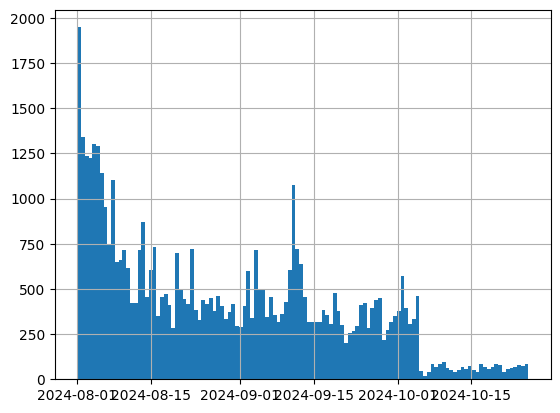

In [43]:
df_english_preprocessed_messages.date.hist(bins=120)

In [ ]:
df_english_preprocessed_messages.channel_id

<Axes: >

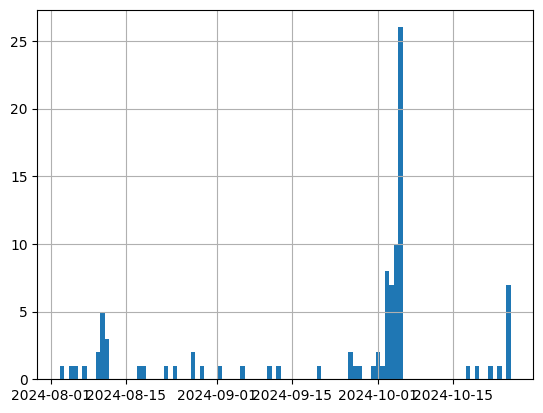

In [47]:
df_english_preprocessed_messages.sort_values(by='date').drop_duplicates(subset='channel_id',keep='last')['date'].hist(bins=100)

In [39]:
                  # estrai il mese (1-12)

# 2️⃣  Trova, per ogni gruppo (channel_id), l’ULTIMO messaggio
last_msg_per_group = (
    df.sort_values('timestamp')       # ordina nel tempo
      .groupby('channel_id')          # raggruppa per gruppo
      .tail(1)                        # prendi l’ultima riga di ogni gruppo
)

# 3️⃣  Conta quanti gruppi hanno come ultimo mese Ago-Nov
target_months = {8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov'}

# tabella di frequenze
counts = last_msg_per_group['month'].value_counts().reindex(target_months.keys(), fill_value=0)

# 4️⃣  Calcola le percentuali
percentages = (counts / len(last_msg_per_group) * 100).round(2)

# 5️⃣  Stampa risultato
print("🔢 Totale gruppi analizzati:", len(last_msg_per_group), "\n")
for m, label in target_months.items():
    print(f"{label:>3}: {counts[m]:>3} gruppi  |  {percentages[m]:>5.2f}%")


🔢 Totale gruppi analizzati: 96 

Aug:  21 gruppi  |  21.88%
Sep:  11 gruppi  |  11.46%
Oct:  64 gruppi  |  66.67%
Nov:   0 gruppi  |   0.00%


In [ ]:
embeddings.shape

In [ ]:
len(df['processed_text'])
# (x,y) x=how many text have been processed, y=how many embeddings have been created

In [ ]:

    
umap_model = UMAP(**umap_params)
hdbscan_model = HDBSCAN(**hdbscan_params)

from sklearn.feature_extraction.text import CountVectorizer
max_features_vectorizer = 1024
min_df_vectorizer = 0.01
max_df_vectorizer = 0.99 

#min_df = 0.01 → una parola deve apparire in almeno 100 documenti per essere tenuta.
#max_df = 0.99 → se una parola appare in più di 9.900 documenti, viene scartata (tipo "the", "and", ecc.).
#max_features = 1024 → anche se hai 10.000 parole valide, tiene solo le 1024 più frequenti.

vectorizer_model = CountVectorizer(
  max_features=max_features_vectorizer, 
  min_df=min_df_vectorizer,
  max_df=max_df_vectorizer)


In [ ]:
t0 = time.time()
topic_model = BERTopic(
    embedding_model=None,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True,
    top_n_words=20,
    language = 'english', 
    vectorizer_model=vectorizer_model
)

topics, probs = topic_model.fit_transform(df['processed_text'],embeddings=embeddings)
print(f"Execution time for {model_name} UMAP: {time.time()-t0}s")

topics=np.array(topics)

In [ ]:
topic_model.save(f'final/final_{model_name}.pkl')
topics=np.array(topic_model.topics_)

In [ ]:
topic_model=BERTopic.load(f'final/final_{model_name}.pkl')
topics=np.array(topic_model.topics_)

In [ ]:
topic_model.visualize_barchart(top_n_topics=-1,n_words=20, width = 350,height=450)

#top_n_topics=-1	Mostra tutti i topic (eccetto outlier -1)	top_n_topics=5 mostrerebbe solo i primi 5 topic più grandi
#n_words=20	Mostra 20 parole per ogni topic nel grafico	Se vuoi vederne solo 10, metti n_words=10
#width=350	Larghezza (in pixel) del grafico	Cambia la dimensione orizzontale del plot
#height=450	Altezza (in pixel) del grafico	Cambia la dimensione verticale del plot

In [ ]:
texts = df['processed_text']
timestamps = pd.to_datetime(df['date'],format="%Y-%m-%d")

topics_over_time = topic_model.topics_over_time(
    list(df['processed_text']),
    list(df['date']),
    nr_bins = timestamps.nunique(),
    global_tuning = False,
    evolution_tuning = True)


In [ ]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    top_n_topics=5)

In [ ]:
umap_model=topic_model.umap_model
reduced_embeddings=umap_model.transform(embeddings)

- reduce outliers

In [ ]:
new_topics = topic_model.reduce_outliers(list(texts), topics , strategy="c-tf-idf", threshold=0.1)

#Quando BERTopic prova a riassegnare un outlier, confronta il suo contenuto testuale con i topic usando una misura di similarità tra vettori TF-IDF.
#Di solito si tratta di una similarità coseno, che varia tra:
#0.0 = nessuna somiglianza
#1.0 = perfetta somiglianza
#0.1 è molto poco



topic_model.update_topics(list(texts), topics=new_topics,
                          vectorizer_model=vectorizer_model,top_n_words=20)
topic_model.get_topic_info()

In [ ]:
new_topics=np.array(new_topics)
pd.Series(new_topics).value_counts(normalize=True)